In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ipynb.fs.full.Functions import calc_Truths, Sensitivity, profile
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,roc_curve, auc,recall_score,precision_score,mean_squared_error
import time
import xgboost as xgb

# Step 1: Data Investigation
---
    
<b> We firstly want to bring in our data and have a look at it. This comes in the form of two files: one filled with information on our Higgs boson events, and another filled with events which look similar but don't contain Higgs bosons. 

We will combine these two files so that they become one big one, and from there we can plot the data in each column to get to grips with what each quantity is.
    
More explination of file structure...

In [6]:
#Read in the training data
df1 = pd.read_csv('./../CSVfiles/ggH.csv')
df2 = pd.read_csv('./../CSVfiles/data_yyjj_p1.csv', nrows=len(df1))

#Calculate weights
num_sigs = len(df1)
num_bkgs = len(df2)
prop = (num_sigs/(num_bkgs+num_sigs))
bkg_w = np.ones((num_bkgs))
sig_w = np.full((num_sigs), 1/(prop))
weights = np.concatenate((sig_w,bkg_w))

print('There is %.2f%% signal data' % (prop*100))

#Full MC dataset 
df = pd.concat([df1,df2])

#Transform data to remove mass bias 
df['g1_pt'] = df['g1_pt']/(df['p_mass'])
df['g2_pt'] = df['g2_pt']/(df['p_mass'])
df['g1_E'] = df['g1_E']/(df['p_mass'])
df['g2_E'] = df['g2_E']/(df['p_mass'])

#Drop columns which have NaN values filled in, as this 
#will allow the classifier to cheat
df.drop(['p_pt','p_E','p_phi','p_eta','g1_trigm','g2_trigm',
         'trigP','g1_ptcone','g2_ptcone','g1_etcone', 'g2_etcone', 'jet_n',
                 'j3_pt','j3_eta','j3_phi','j3_E','j3_MV2C10','j4_pt','j4_eta','j4_phi','j4_E','j4_MV2C10',
                 'j5_pt','j5_eta','j5_phi','j5_E','j5_MV2C10','j6_pt','j6_eta','j6_phi','j6_E','j6_MV2C10',
                 'j7_pt','j7_eta','j7_phi','j7_E','j7_MV2C10','j8_pt','j8_eta','j8_phi','j8_E','j8_MV2C10',
                 'j9_pt','j9_eta','j9_phi','j9_E','j9_MV2C10','j10_pt','j10_eta','j10_phi','j10_E','j10_MV2C10',
                 'j11_pt','j11_eta','j11_phi','j11_E','j11_MV2C10','j12_pt','j12_eta','j12_phi','j12_E','j12_MV2C10',
                 'j13_pt','j13_eta','j13_phi','j13_E','j13_MV2C10','j14_pt','j14_eta','j14_phi','j14_E','j14_MV2C10',
                 'j15_pt','j15_eta','j15_phi','j15_E','j15_MV2C10'], axis = 1, inplace = True)

for i in range(1,3):
    df.drop(['j{}_MV2C10'.format(i)], axis = 1, inplace = True)

#Read in scale factor data
sf1 = pd.read_csv('./../CSVfiles/ggH_sf.csv')
sf1['comb'] = sf1['sf_pileup'] * sf1['sf_photon'] * sf1['sf_trigger']
sf2 = pd.read_csv('./../CSVfiles/sf_yyjj_p1.csv', nrows=len(sf1))
sf3 = pd.concat([sf1['comb'],sf2['m_weight']], ignore_index=True, axis = 0)

#Split MC data into training and validation sets
x_train, x_val, y_train, y_val, m_train, m_val, sf_train, sf_val = train_test_split(df.iloc[:, 2:],
                                                                    df.iloc[:, 0], df.iloc[:, 1].values,
                                                                    sf3.values,
                                                                    test_size=0.2, shuffle = True)

#Calculate scale factors
SB_ggjj = len(df2[(df2['p_mass'] < 121) | (df2['p_mass'] > 129)])
sf_trim = [len(df[df['label']==1])/len(y_val[y_val==1]), len(df[df['label']==0])/len(y_val[y_val==0])]
print('sf_trim : ', sf_trim)

#Convert to dtype for XGBoost
dtrain = xgb.DMatrix(data = x_train, label = y_train)
dval = xgb.DMatrix(data = x_val, label = y_val)

#To perform operations on disk instead of in RAM (for large files)
# dtrain = xgb.DMatrix(data = './../CSVfiles/training_data.csv?format=csv&label_column=0#traincache')
# dval = xgb.DMatrix(data = './../CSVfiles/validation_data.csv?format=csv&label_column=0#valcache')

#Clear unnecessary memory use
del df, df1, df2, sf1, sf2, sf3

#Read in data
df1 = pd.read_csv('./../CSVfiles/dataA.csv')
df2 = pd.read_csv('./../CSVfiles/dataB.csv')
df3 = pd.read_csv('./../CSVfiles/dataC.csv')
df4 = pd.read_csv('./../CSVfiles/dataD.csv')

df5 = pd.concat([df1,df2])
del df1, df2
df6 = pd.concat([df3,df4])
del df3,df4
df = pd.concat([df5,df6])
del df5,df6

SB_data = len(df[(df['p_mass'] < 121) | (df['p_mass'] > 129)])
SF_band = SB_data/SB_ggjj
print('Side band SF: %.2f'%SF_band, ' data side band: %.2f '%SB_data, ' bkg side band: %.2f '%SB_ggjj)

#Clear unnecessary memory use
del df

There is 50.00% signal data
sf_trim :  [4.988278624243782, 5.011755436273717]
Side band SF: 0.13  data side band: 77460.00   bkg side band: 602199.00 


# Step 2: Train the Model
---

<b> Now that our data is in its correct form, we can pass it into a machine learning (ML) algorithm. 

For this project, we will be using an implementation of Boosted Decision Trees known as XGBoost. Importing XGBoost makes it easy for us to quickly train our classifier. 
    
More explination of ML...

In [7]:
#Set error function, nthread is for No. CPU threads
#Watchlist prints error statistics, num_round is iterations
param = {'objective':'binary:logistic', 'nthread': '-1', 'eta':'0.09'}
watchlist = [(dtrain, 'train'),(dval, 'eval')]
num_round = 100

#Fit the model to the training data
training_start = time.perf_counter()
model = xgb.train(param, dtrain, num_round, watchlist)
training_end = time.perf_counter()

[18:56:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.66852	eval-logloss:0.66885
[1]	train-logloss:0.64900	eval-logloss:0.64895
[2]	train-logloss:0.63207	eval-logloss:0.63213
[3]	train-logloss:0.61715	eval-logloss:0.61723
[4]	train-logloss:0.60362	eval-logloss:0.60353
[5]	train-logloss:0.59200	eval-logloss:0.59207
[6]	train-logloss:0.58250	eval-logloss:0.58237
[7]	train-logloss:0.57320	eval-logloss:0.57322
[8]	train-logloss:0.56552	eval-logloss:0.56552
[9]	train-logloss:0.55842	eval-logloss:0.55842
[10]	train-logloss:0.55225	eval-logloss:0.55230
[11]	train-logloss:0.54584	eval-logloss:0.54586
[12]	train-logloss:0.54080	eval-logloss:0.54086
[13]	train-logloss:0.53625	eval-logloss:0.53634
[14]	train-logloss:0.53242	e

<b> Below, we visualise the tree that we created as well as rank which features of the data have allowed our model to learn the most. This is useful as it gives us insight into what the model is doing/learning about, and could highlight potential problems.
    
We can see the best discriminants are...

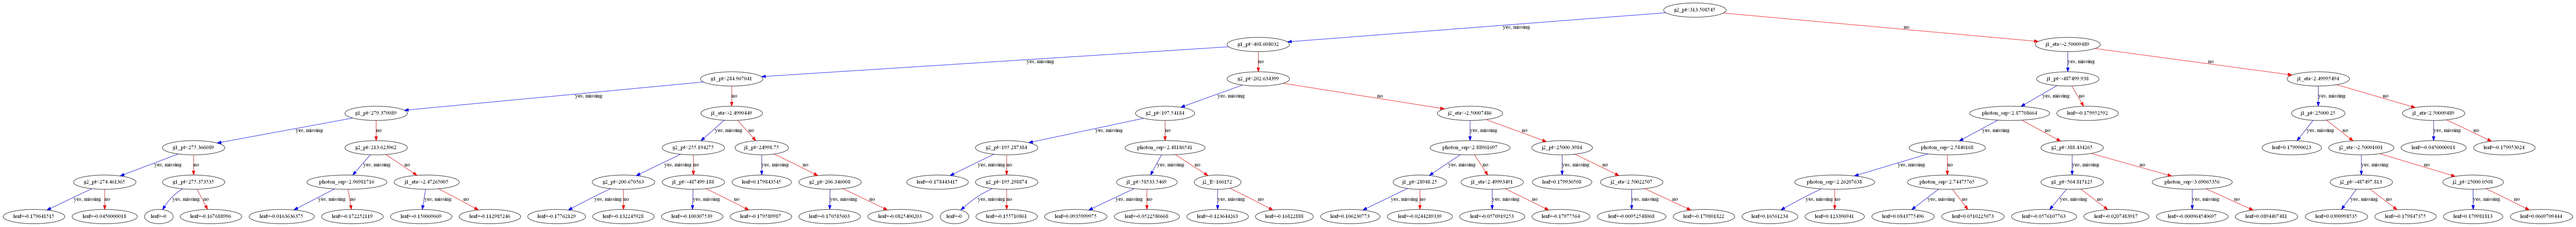

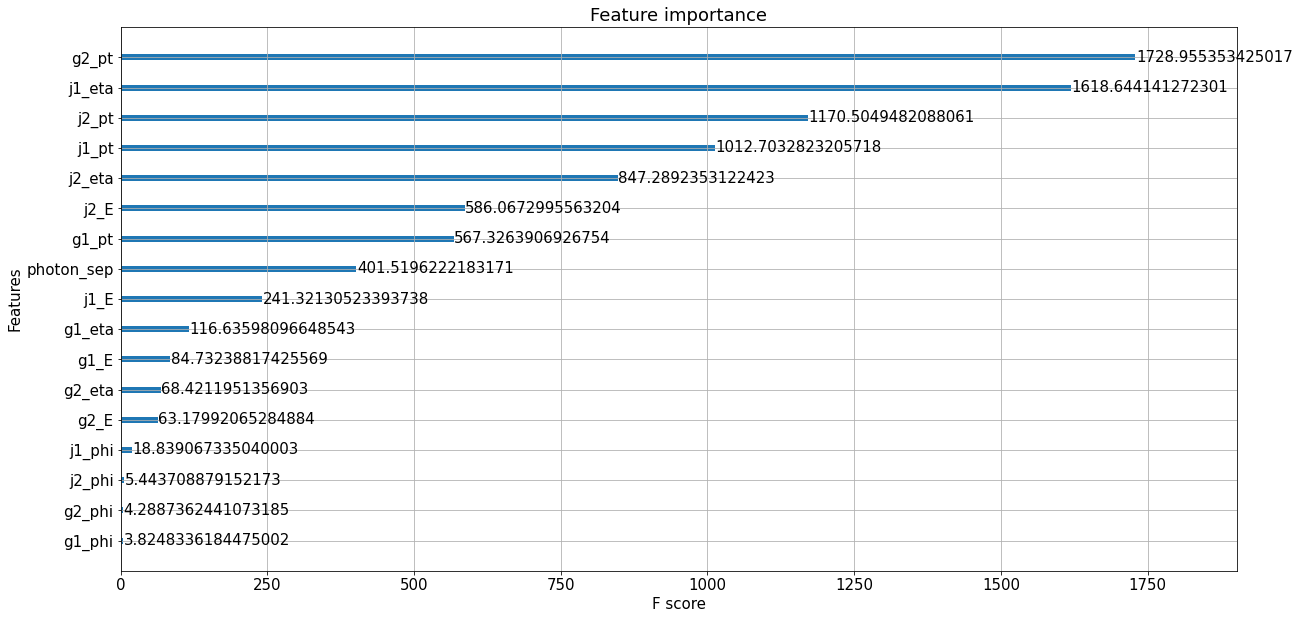

In [8]:
#Visualise the tree
plt.rcParams['figure.figsize'] = [200, 100]
xgb.plot_tree(model)
plt.show()

#Demonstrate the feature importances
plt.rcParams.update({'font.size': 15})
plt.rcParams['figure.figsize'] = [20,10]
xgb.plot_importance(model, importance_type='gain')
plt.show()

# Step 3: Evaluate the Model
---
<b> Now that we have a trained classifier, we can use it to predict labels of the data. 
We evaluate our model by comparing our predictions to the labels that we know are correct. From this, many metrics can be gathered.
Generating an Reciever Operating Characteristic (ROC) curve, is a good way to tell us about how well the classifier performs. This curve plots the false positive rate against the true positive rate of the classifier, and tells us about the proportions of each class which are correctly classified. The dotted red line would indicate a classifier which is simply guessing at labels, whereas a line which bends into the top left corner is better.

Training time was: 46.32052589999998
Prediction time was: 0.1015980999999897
Number of correct predictions:  211237  and number of incorrect:  73726
Accuracy: 74.13%


<Figure size 1200x600 with 0 Axes>

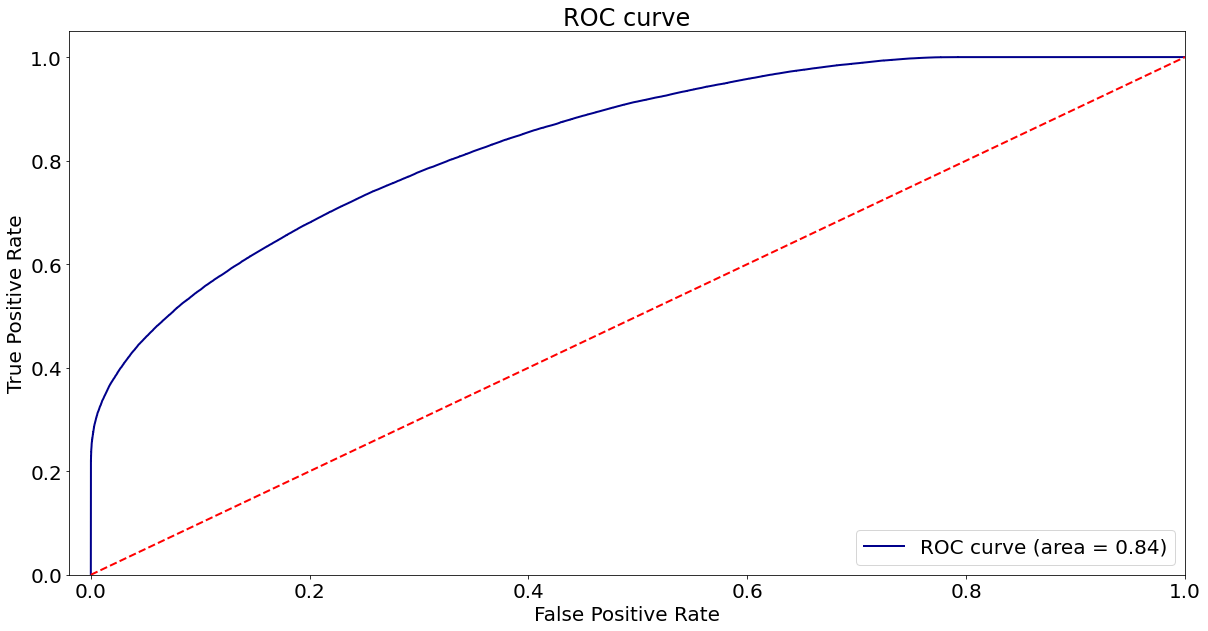

In [9]:
#To observe model behaviour, compare original labels to validation set
prediction_start = time.perf_counter()
predictions = model.predict(dval)
prediction_end = time.perf_counter()
y_preds = np.rint(predictions)

#Evaluate how well the model performs

#Time efficiency
xgb_train_time = training_end-training_start
xgb_prediction_time = prediction_end-prediction_start
print('Training time was: {}'.format(xgb_train_time))
print('Prediction time was: {}'.format(xgb_prediction_time))

tru = 0
fal = 0
labels = y_val.values
for i in range(len(labels)):
    if labels[i] == y_preds[i]:
        tru += 1
    elif labels[i] != y_preds[i]:
        fal += 1
    else:
        print('Error')

print('Number of correct predictions: ', tru, ' and number of incorrect: ', fal)

#Show accuracy
accuracy = accuracy_score(labels, y_preds)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

#Plot ROC curve
plt.figure(figsize=(12,6), dpi= 100)
fpr, tpr, _ = roc_curve(labels, predictions)
roc_auc = auc(fpr, tpr)
plt.rcParams.update({'font.size': 20})
plt.figure()
plt.plot(fpr, tpr, color='darkblue',
        lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

# Step 4: Find the Best Sensitivity
---
<b> Before going ahead with our model and trying to predict on the non-simulated data, there is one more refinement which we can make. 
Currently our predictions are rounded to 1 and 0 based on a threshold of 0.5. While this is intuitive, this number can actually be tuned to give a more significant 'Higgs bump' later on. The idea behind this step is to figure out which predictions are classified as what at various threshold cuts from 0 to 1. At each threshold we calculate a sensitivity, then we choose the threshold with the highest sensitivity as the cut which gives us the best class separation.

In [15]:
#Sensitivity over different cuts
ss = []
t = np.linspace(0.1,0.95,20,endpoint=True)
for i in t:
    true_pos, false_pos, true_neg, false_neg = calc_Truths(predictions, y_val.values, m_val, sf_val, threshold = i)
    eff_sig = len(true_pos)/(len(true_pos)+len(false_neg))
    eff_bkg = len(false_pos)/(len(false_pos)+len(true_neg))
    sensitivity = Sensitivity(true_pos, false_pos, sf_trim, SF_band)
    ss.append(sensitivity)
    print('Sensitivity on cut %.2f: '%i, '%.2f' % sensitivity,' with effsig: %.2f' % eff_sig,' with rj: %.2f'% eff_bkg)
best_cut = t[ss.index(max(ss))]
print('Best at: %.2f'% best_cut)

#Plot sensitivities
plt.plot(t, ss, label = 'Sensitivity on Cut')
plt.xlabel('Prediction Cut')
plt.ylabel('Sensitivity')
plt.legend()
plt.show()

IndexError: index 91888 is out of bounds for axis 0 with size 91888

<b> We can now clearly see the cut with the best sensitivity. Let's separate our events based on this cut, and plot the mass spectrum of everything the classifier thinks is a Higgs Boson. We should be able to see all the mis-classified background events as a smoothly falling blue line, and our Higgs events as a large red spike on approximately 125 GeV.

In [14]:
#Get info for the best cut
true_pos, false_pos, true_neg, false_neg = calc_Truths(predictions, y_val.values, m_val, sf_val, threshold = 0.7)
eff_sig = len(true_pos)/(len(true_pos)+len(false_neg))
eff_bkg = len(false_pos)/(len(false_pos)+len(true_neg))
sensitivity = Sensitivity(true_pos, false_pos, sf_trim, SF_band)
print('Best effsig: %.2f'%  eff_sig)
print('Best rj: %.2f'%  eff_bkg)
print('Best Sensitivity: %.2f'%  sensitivity)

bkg_masses = [i[0] for i in false_pos]
signal_masses = [i[0] for i in true_pos]

#Plot resulting mass spectrum passing cut
plt.figure(figsize=(12,6), dpi= 100)
xlims=[100, 170]
bins = np.linspace(xlims[0],xlims[1],100,endpoint=True)
plt.hist(bkg_masses, color = 'darkblue', histtype='step', density = True, bins=bins,linewidth=2)
plt.hist(signal_masses, color = 'red', histtype='step', density = True, bins=bins,linewidth=2)
plt.xlabel('Invariant Mass [GeV]')
plt.ylabel('Fraction of Events')
plt.show()

#Plot mass sculpting graph
profile(m_val[y_val==0], y_preds[y_val==0], labels='BDT Sculpting')

IndexError: index 91888 is out of bounds for axis 0 with size 91888

# Step 5: Find the Higgs Boson!
---
<b> We now have a trained and evaluated ML model. We are now ready to apply this to the data where we don't already know what the labels are. Hopefully, it will be able to predict the labels well enough for us to see the Higgs spike amongst the background processes.
    
We begin the same way as before: reading in the data and pushing it all together. We need to make sure it is in the same format as the training data, or else we won't be able to predict the labels.

In [16]:
#Read in each data for predicting the labels
df1 = pd.read_csv('./../CSVfiles/dataA.csv')
df2 = pd.read_csv('./../CSVfiles/dataB.csv')
df3 = pd.read_csv('./../CSVfiles/dataC.csv')
df4 = pd.read_csv('./../CSVfiles/dataD.csv')

df5 = pd.concat([df1,df2])
del df1, df2
df6 = pd.concat([df3,df4])
del df3,df4
df = pd.concat([df5,df6])
del df5,df6

df['g1_pt'] = df['g1_pt']/(df['p_mass'])
df['g2_pt'] = df['g2_pt']/(df['p_mass'])
df['g1_E'] = df['g1_E']/(df['p_mass'])
df['g2_E'] = df['g2_E']/(df['p_mass'])

df.drop(['p_pt','p_E','p_phi','p_eta','g1_trigm','g2_trigm',
         'trigP','g1_ptcone','g2_ptcone','g1_etcone','g2_etcone', 'jet_n',
                 'j3_pt','j3_eta','j3_phi','j3_E','j3_MV2C10','j4_pt','j4_eta','j4_phi','j4_E','j4_MV2C10',
                 'j5_pt','j5_eta','j5_phi','j5_E','j5_MV2C10','j6_pt','j6_eta','j6_phi','j6_E','j6_MV2C10',
                 'j7_pt','j7_eta','j7_phi','j7_E','j7_MV2C10','j8_pt','j8_eta','j8_phi','j8_E','j8_MV2C10',
                 'j9_pt','j9_eta','j9_phi','j9_E','j9_MV2C10','j10_pt','j10_eta','j10_phi','j10_E','j10_MV2C10',
                 'j11_pt','j11_eta','j11_phi','j11_E','j11_MV2C10','j12_pt','j12_eta','j12_phi','j12_E','j12_MV2C10',
                 'j13_pt','j13_eta','j13_phi','j13_E','j13_MV2C10','j14_pt','j14_eta','j14_phi','j14_E','j14_MV2C10',
                 'j15_pt','j15_eta','j15_phi','j15_E','j15_MV2C10'], axis = 1, inplace = True)

for i in range(1,3):
    df.drop(['j{}_MV2C10'.format(i)], axis = 1, inplace = True)

x_data = df.iloc[:,1:]
m_data = df['p_mass'].values

#We can now predict labels of the data
dtest = xgb.DMatrix(data = x_data)
predictions = model.predict(dtest)
y_preds = np.rint(predictions)

<b> Our last step is to plot the mass spectrum of our predicted signal, using the best threshold cut that we calculated before. Remember that we will not see a similar mass spectrum plot as in our evaluation. This is becuase we did not know our labels beforehand for this data, making it impossible to distinguish between background and signal events which pass our cut. Instead we will see our background added to our singal, which should appear as an excess bump on the smoothly falling background distribution.

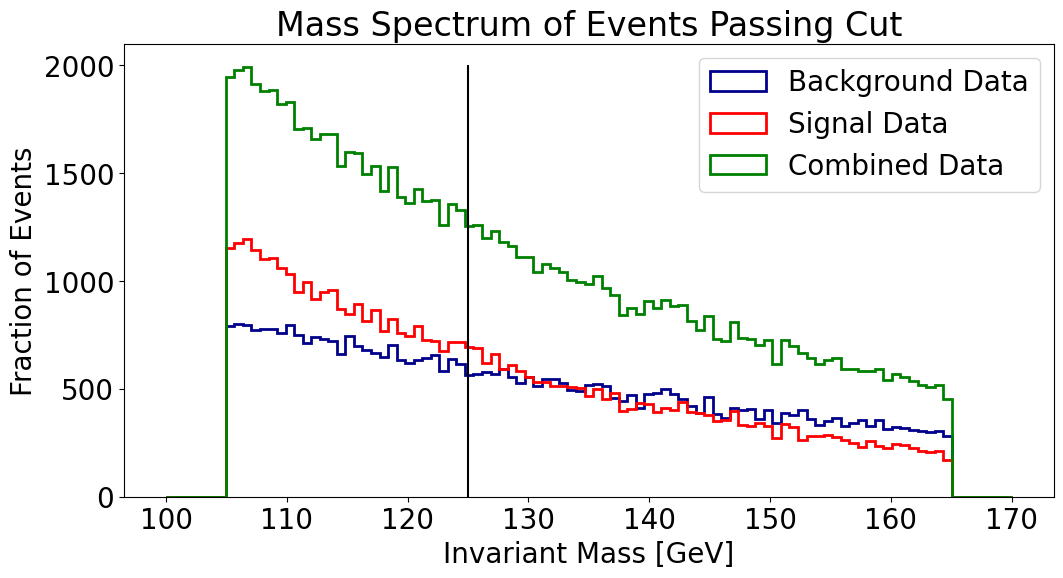

47696
44192


In [21]:
#Do a plot of the mass spectrum
plt.figure(figsize=(12,6), dpi= 100)
sigs = m_data[predictions >= 0.5]
bkgs = m_data[predictions < 0.5]
xlims=[100, 170]
bins = np.linspace(xlims[0],xlims[1],100,endpoint=True)
plt.hist(bkgs, color = 'darkblue', histtype='step', bins=bins,linewidth=2,label='Background Data')
plt.hist(sigs, color = 'red', histtype='step', bins=bins,linewidth=2,label='Signal Data')
plt.hist(m_data, color = 'green', histtype='step', bins=bins,linewidth=2,label='Combined Data')
plt.xlabel('Invariant Mass [GeV]')
plt.ylabel('Fraction of Events')
plt.title('Mass Spectrum of Events Passing Cut')
plt.vlines(125,0,2000)
plt.legend()
plt.show()
print(len(sigs))
print(len(bkgs))